In [1]:
import os, sys
print("CWD:", os.getcwd())
print("sys.path[0]:", sys.path[0])

CWD: /workspaces/COMP560FinalProject/notebooks
sys.path[0]: /workspaces/COMP560FinalProject/notebooks


In [2]:
import os, sys

# Go up one directory from notebooks/ to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Added to sys.path:", PROJECT_ROOT)

Added to sys.path: /workspaces/COMP560FinalProject


In [3]:
from src.model import load_raw_data, add_targets, run_classification_models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = load_raw_data("../data/merged.csv")
df = add_targets(df)

df[["Country", "Year", "GDP_per_capita", "high_gdp"]].head()

,Country,Year,GDP_per_capita,high_gdp
0,Algeria,1990,2445.182658,1
1,Algeria,1991,1759.111407,1
2,Algeria,1992,1802.693008,1
3,Algeria,1993,1831.048573,1
4,Algeria,1994,1525.540789,1


In [4]:
results = run_classification_models(df, models=["logreg_gd", "logreg_liblinear"])

for name, res in results.items():
    print(f"{name}: accuracy={res.accuracy:.3f}, f1={res.f1:.3f}")

logreg_gd: accuracy=0.848, f1=0.862
logreg_liblinear: accuracy=0.848, f1=0.859


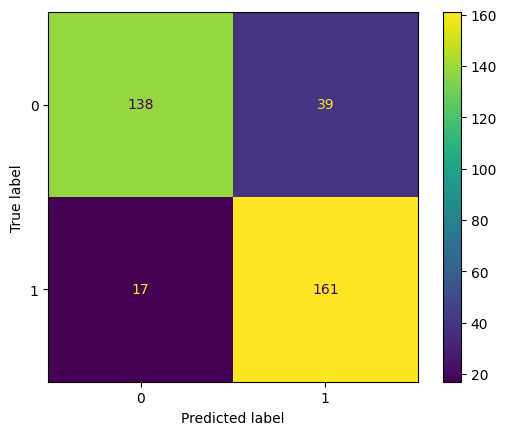

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.model import train_test_split_all, make_classification_pipeline

X_train, X_test, _, _, y_train, y_test = train_test_split_all(df)
pipe = make_classification_pipeline("logreg_gd")
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()


In [6]:
clf_results = run_classification_models(
    df,
    models=["logreg_liblinear", "logreg_gd"],
)

clf_df = pd.DataFrame([
    {
        "model": name,
        "accuracy": res.accuracy,
        "f1": res.f1,
    }
    for name, res in clf_results.items()
])

clf_df

,model,accuracy,f1
0,logreg_liblinear,0.847887,0.859375
1,logreg_gd,0.836620,0.822086


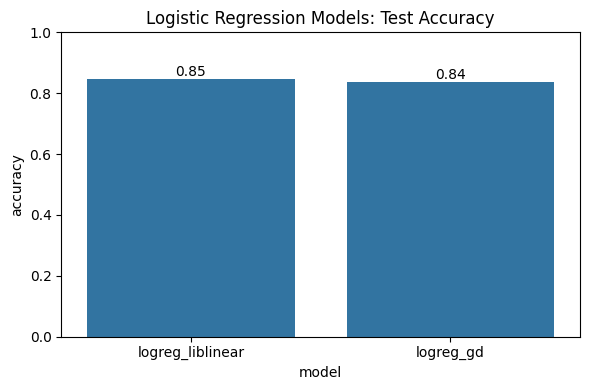

In [7]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=clf_df.sort_values("accuracy", ascending=False),
    x="model",
    y="accuracy",
)
plt.title("Logistic Regression Models: Test Accuracy")
plt.ylim(0, 1)
for i, row in clf_df.sort_values("accuracy", ascending=False).reset_index().iterrows():
    plt.text(i, row["accuracy"] + 0.01, f"{row['accuracy']:.2f}", ha="center")
plt.tight_layout()
plt.show()

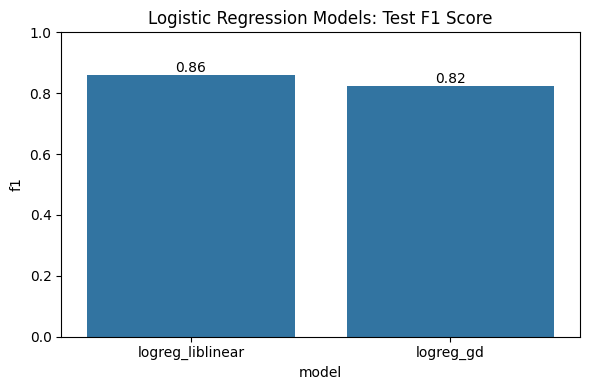

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=clf_df.sort_values("f1", ascending=False),
    x="model",
    y="f1",
)
plt.title("Logistic Regression Models: Test F1 Score")
plt.ylim(0, 1)
for i, row in clf_df.sort_values("f1", ascending=False).reset_index().iterrows():
    plt.text(i, row["f1"] + 0.01, f"{row['f1']:.2f}", ha="center")
plt.tight_layout()
plt.show()

/tmp/ipykernel_25409/4227201973.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


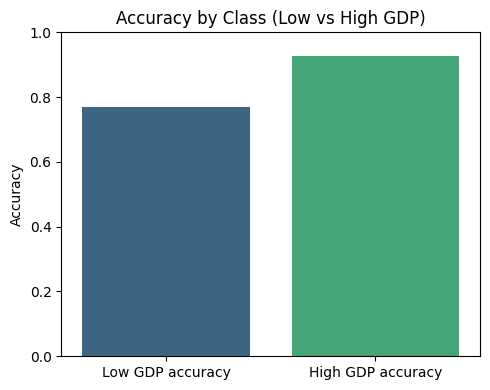

In [10]:
import numpy as np

class_accuracy = {
    "Low GDP accuracy": np.mean(y_pred[y_test == 0] == 0),
    "High GDP accuracy": np.mean(y_pred[y_test == 1] == 1)
}

plt.figure(figsize=(5, 4))
sns.barplot(
    x=list(class_accuracy.keys()),
    y=list(class_accuracy.values()),
    palette="viridis"
)
plt.title("Accuracy by Class (Low vs High GDP)")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

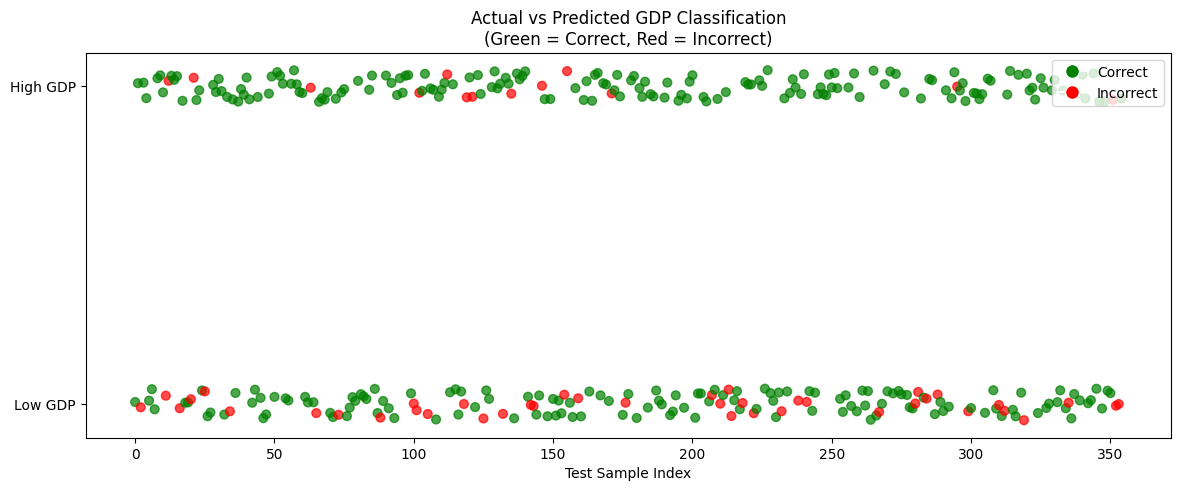

In [23]:


def plot_classification_results(y_test, y_pred):
    correct = (y_test == y_pred)

    # jitter to visually separate points
    jitter = np.random.uniform(-0.05, 0.05, size=len(y_test))
    y_jittered = y_test + jitter

    plt.figure(figsize=(14, 5))

    plt.scatter(
        np.arange(len(y_test)),
        y_jittered,
        c=np.where(correct, "green", "red"),
        alpha=0.7,
        s=40,
        label=None,
    )

    plt.yticks([0, 1], ["Low GDP", "High GDP"])
    plt.xlabel("Test Sample Index")
    plt.title("Actual vs Predicted GDP Classification\n(Green = Correct, Red = Incorrect)")

    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label="Correct", markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', label="Incorrect", markerfacecolor='red', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc="upper right")

    plt.show()

plot_classification_results(y_test, y_pred)

In [25]:
import json
from pathlib import Path

clf_results_dict = {
    name: {
        "model_name": res.model_name,
        "accuracy": float(res.accuracy),
        "f1": float(res.f1),
    }
    for name, res in clf_results.items()
}

output_dir = Path(PROJECT_ROOT) / "AI"
output_dir.mkdir(exist_ok=True)

with open(output_dir / "classification_results.json", "w") as f:
    json.dump(clf_results_dict, f, indent=2)

print("Saved classification results to", output_dir / "classification_results.json")


Saved classification results to /workspaces/COMP560FinalProject/AI/classification_results.json
